<a href="https://colab.research.google.com/github/juangallon08/clasificador_movimientos/blob/main/Model/Trabajo_Grado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive


In [ ]:
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Nueva sección

In [ ]:
!pip install opencv-python

In [ ]:
import os
import json
import cv2
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from google.colab import drive


In [ ]:

# Definir parámetros
drive.mount('/content/drive')
num_classes = 2 # Número de clases de movimientos
input_shape = (20, 112, 112, 1) # Forma de la entrada: (longitud del clip, altura, anchura, canales)
batch_size = 128 #120 #24 #480 96  # Tamaño del lote
epochs = 10 # Número de épocas

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Leer los datos
def load_data(video_folder, label_folder):
    # Crear listas vacías para almacenar los vídeos y las etiquetas
    videos = []
    labels = []

    # Diccionario de mapeo de etiquetas si es necesario
    label_mapping = {"sospechoso": 0, "no sospechoso": 1}

    # Recorrer los archivos en la carpeta de vídeos
    for filename in os.listdir(video_folder):
        # Obtener el nombre del vídeo sin la extensión
        video_name = os.path.splitext(filename)[0]
        # Leer el vídeo como una secuencia de imágenes usando OpenCV
        video = cv2.VideoCapture(os.path.join(video_folder,filename))
        # Crear una lista vacía para almacenar las imágenes del vídeo
        frames = []
        # Recorrer las imágenes del vídeo
        while video.isOpened():
            # Leer una imagen del vídeo
            ret, frame = video.read()
            # Si se pudo leer la imagen
            if ret:
                # Redimensionar la imagen a 112x112 píxeles
                frame = cv2.resize(frame,(112,112))
                # Conversion a escala de grises
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
                # Añadir la imagen a la lista de frames
                frames.append(frame)
            # Si no se pudo leer la imagen
            else:
                # Salir del bucle
                break
        # Liberar el vídeo
        video.release()
        # Convertir la lista de frames en un array numpy
        frames = np.array(frames)
        # Añadir el array a la lista de vídeos
        videos.append(frames)
        # Leer el archivo json correspondiente al vídeo usando la librería json
        with open(os.path.join(label_folder, video_name + ".mp4.json")) as f:
            label_data = json.load(f)
        # Extraer la etiqueta de la clase de los datos del JSON
        # Suponiendo que solo haya una etiqueta en "tags", de lo contrario, deberás manejarlo de acuerdo a tu caso específico
        label = label_data["tags"][0]["name"]
        # Mapear la etiqueta si es necesario
        if label_mapping and label in label_mapping:
            label = label_mapping[label]
        else:
            raise ValueError(f"Etiqueta no mapeada: {label}")
        # Añadir la etiqueta a la lista de etiquetas
        labels.append(label)
    # Convertir las listas en arrays numpy
    videos = np.array(videos,dtype=object)
    labels = np.array(labels)
    # Devolver los arrays de vídeos y etiquetas
    return videos, labels


In [ ]:
# Dividir los datos en conjuntos de entrenamiento (80%), validación (10%) y prueba (10%)
videos_train, labels_train = load_data ("/content/drive/My Drive/Colab Notebooks/VD/train/v5","/content/drive/My Drive/Colab Notebooks/VD/train/label")
videos_val, labels_val = load_data ("/content/drive/My Drive/Colab Notebooks/VD/val/v5","/content/drive/My Drive/Colab Notebooks/VD/val/label5")
videos_test, labels_test = load_data("/content/drive/My Drive/Colab Notebooks/VD/test/v5","/content/drive/My Drive/Colab Notebooks/VD/test/label")
videos_train2, labels_train2 = load_data ("/content/drive/My Drive/Colab Notebooks/VD/train/v2","/content/drive/My Drive/Colab Notebooks/VD/train/label2")
videos_test2, labels_test2 = load_data("/content/drive/My Drive/Colab Notebooks/VD/test/v2","/content/drive/My Drive/Colab Notebooks/VD/test/label2")


In [ ]:
def video_ajuste(videos_ajus):
    num_frames1 = 20
    videos_test_adjusted  = []
    for video in videos_ajus:
        if video.shape[0] != num_frames1:
           if video.shape[0] < num_frames1:
              # Rellenar con frames en blanco si es necesario
              frames_faltantes1 = num_frames1 - video.shape[0]
              frames_en_blanco1 = np.zeros_like(video[0])  # Crear un frame en blanco con las mismas dimensiones que los otros
              frames_en_blanco1 = np.expand_dims(frames_en_blanco1, axis=0)  # Agregar una dimensión al frame en blanco
              video_adjusted = np.pad(video, ((0, frames_faltantes1), (0, 0), (0, 0)), mode='constant', constant_values=0)
           else:
                # Recortar si hay más frames que num_frames
                video_adjusted = video[:num_frames]
        else:
            video_adjusted = video
        videos_test_adjusted.append(video_adjusted)

    videos_ajus  = np.array(videos_test_adjusted)
    video_shape = video.shape  # Obtener la forma actual del video
    #videos_ajus = tf.convert_to_tensor(videos_test, dtype=tf.float32)

    return videos_ajus


In [ ]:
videos_train = video_ajuste(videos_train)
videos_test = video_ajuste(videos_test)
videos_train2 = video_ajuste(videos_train2)
videos_test2 = video_ajuste(videos_test2)
videos_train = tf.convert_to_tensor(videos_train, dtype=tf.float32)
videos_test = tf.convert_to_tensor(videos_test, dtype=tf.float32)
videos_val = tf.convert_to_tensor(videos_val, dtype=tf.float32)
videos_train2 = tf.convert_to_tensor(videos_train2, dtype=tf.float32)
videos_test2 = tf.convert_to_tensor(videos_test2, dtype=tf.float32)

print(videos_train.shape)
print(videos_val.shape)
print(videos_test.shape)
print(videos_train2.shape)
print(videos_test2.shape)

print(labels_test2.shape)

(128, 20, 112, 112)
(32, 20, 112, 112)
(60, 20, 112, 112)
(300, 20, 112, 112)
(100, 20, 112, 112)
(100,)


In [ ]:
# Normalizar los datos
videos_train = videos_train / 255.0
videos_val = videos_val / 255.0
videos_test = videos_test / 255.0
videos_train2 = videos_train2 / 255.0
videos_test2 = videos_test2 / 255.0

In [ ]:
print(videos_train.shape)
print(videos_val.shape)
print(videos_test.shape)
print(videos_train2.shape)
print(videos_test2.shape)


(128, 20, 112, 112)
(32, 20, 112, 112)
(60, 20, 112, 112)
(300, 20, 112, 112)
(100, 20, 112, 112)


In [ ]:
# Definir la arquitectura de la red neuronal CNN 3D
def build_model(input_shape, num_classes):
    # Crear la entrada de la red
    inputs = keras.Input(shape=input_shape)
    # Aplicar una capa de convolución 3D con 32 filtros de 3x3x3 y activación ReLU
    x = layers.Conv3D(filters=32, kernel_size=3, activation="relu", padding="same")(inputs)
    # Aplicar una capa de convolución 3D con 64 filtros de 3x3x3 y activación ReLU
    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu", padding="same")(x)
    # Aplicar una capa de agrupación máxima 3D con tamaño de ventana de 2x2x2
    x = layers.MaxPool3D(pool_size=2)(x)
    # Aplicar una capa de convolución 3D con 128 filtros de 2x2x2 y activación ReLU
    x = layers.Conv3D(filters=128, kernel_size=3, activation="relu", padding="same")(x)
    # Aplicar una capa de convolución 3D con 128 filtros de 2x2x2 y activación ReLU
    x = layers.Conv3D(filters=128, kernel_size=3, activation="relu", padding="same")(x)
    # Aplicar una capa de agrupación máxima 3D con tamaño de ventana de 2x2x2
    #x = layers.Conv3D(filters=128, kernel_size=3, activation="relu", padding="same")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    # Aplicar una capa de convolución 3D con 256 filtros de 2x2x2 y activación ReLU
    x = layers.Conv3D(filters=256, kernel_size=2, activation="relu", padding="same")(x)
    # Aplicar una capa de convolución 3D con 256 filtros de 2x2x2 y activación ReLU
    #x = layers.Conv3D(filters=256, kernel_size=2, activation="relu", padding="same")(x)
    # Aplicar una capa de agrupación máxima 3D con tamaño de ventana de 2x2x2
    x = layers.MaxPool3D(pool_size=2)(x)
    # Aplicar una capa de aplanamiento para convertir el tensor en un vector
    x = layers.Flatten()(x)
    # Aplicar una capa densa con 512 unidades y activación ReLU
    x = layers.Dense(units=512, activation="relu")(x)
    # Aplicar una capa densa con el número de clases y activación softmax
    outputs = layers.Dense(units=num_classes, activation="softmax")(x)
    # Crear el modelo usando la API funcional de Keras
    model = keras.Model(inputs, outputs, name="cnn_3d")
    # Devolver el modelo
    return model


In [ ]:
# esayo de otra red neuronal
def build_model(input_shape, num_classes):

    inputs = keras.Input(shape=input_shape)

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu",padding="same")(inputs)
    #x = layers.Conv3D(filters=32, kernel_size=3, activation="relu", padding="same")(x)
    x = layers.MaxPool3D(pool_size=2)(x) # Ajustar el tamaño y los strides

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu", padding="same")(x)
    #x = layers.Conv3D(filters=64, kernel_size=3, activation="relu",padding="same")(x)
    #x = layers.Conv3D(filters=64, kernel_size=3, activation="relu", padding="same")(x)
    #x = layers.Conv3D(filters=526, kernel_size=3, activation="relu", padding="same")(x)
    x = layers.MaxPool3D(pool_size=2)(x)  # Ajustar el tamaño y los strides


    x = layers.Conv3D(filters=128, kernel_size=3, activation="relu",padding="same")(x)
    x = layers.MaxPool3D(pool_size=2)(x) # Ajustar el tamaño y los strides


    x = layers.Conv3D(filters=256, kernel_size=3, activation="relu",padding="same")(x)
    x = layers.MaxPool3D(pool_size=2)(x)  # Ajustar el tamaño y los strides

    x = layers.Flatten()(x)

    x = layers.Dense(units=512, activation="relu")(x)


    outputs = layers.Dense(units=num_classes, activation="softmax")(x)

    # Crear el modelo usando la API funcional de Keras
    model = keras.Model(inputs, outputs, name="cnn_3d")

    return model



In [ ]:
# Crear el modelo
model = build_model(input_shape, num_classes)

# Compilar el modelo
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

# Definir la ruta donde deseas guardar el modelo en tu Google Drive
#model_save_path = "/content/drive/My Drive/Colab Notebooks/VD/modelo_entrenado.h5"



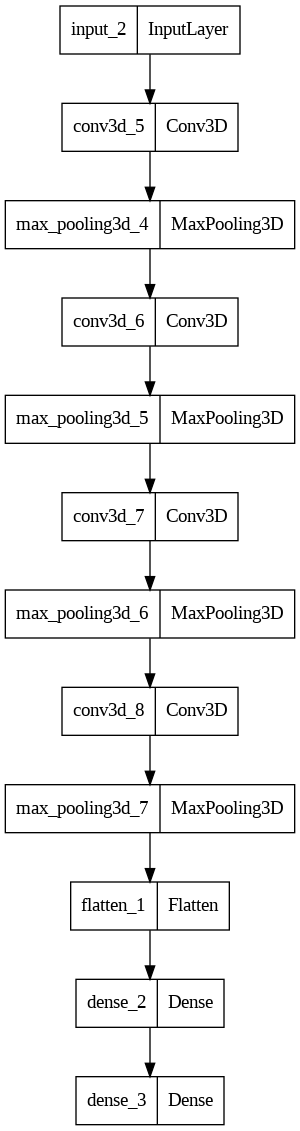

In [ ]:
tf.keras.utils.plot_model(model)

In [ ]:
# Entrenar el modelo
model.fit(
    videos_train,
    labels_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(videos_val, labels_val),
)



Epoch 1/10
1/1 [==============================] - 282s 282s/step - loss: 0.6965 - accuracy: 0.4688 - val_loss: 0.8852 - val_accuracy: 0.5312
Epoch 2/10
1/1 [==============================] - 279s 279s/step - loss: 0.9377 - accuracy: 0.5078 - val_loss: 0.7498 - val_accuracy: 0.4688
Epoch 3/10
1/1 [==============================] - 277s 277s/step - loss: 0.7392 - accuracy: 0.4922 - val_loss: 0.6970 - val_accuracy: 0.4688
Epoch 4/10
1/1 [==============================] - 276s 276s/step - loss: 0.6951 - accuracy: 0.4922 - val_loss: 0.6936 - val_accuracy: 0.4688
Epoch 5/10
1/1 [==============================] - 278s 278s/step - loss: 0.6931 - accuracy: 0.4922 - val_loss: 0.6927 - val_accuracy: 0.4688
Epoch 6/10
1/1 [==============================] - 276s 276s/step - loss: 0.6926 - accuracy: 0.4922 - val_loss: 0.6913 - val_accuracy: 0.5938
Epoch 7/10
1/1 [==============================] - 285s 285s/step - loss: 0.6919 - accuracy: 0.5000 - val_loss: 0.6890 - val_accuracy: 0.5312
Epoch 8/10
1/

In [ ]:

# Evaluar el modelo
model.evaluate(videos_test, labels_test)
#```

2/2 [==============================] - 3s 1s/step - loss: 0.6436 - accuracy: 0.6667


[0.6435760259628296, 0.6666666865348816]

In [ ]:
model.save("/content/drive/My Drive/Colab Notebooks/VD/modelo_entrenado3.h5")
#guarda los pesos
model.save_weights("/content/drive/My Drive/Colab Notebooks/VD/pesos_modelo3.h5")


ENTRENAMIENTO DEL MODELO OPTENIDO CON NUEVOS DATOS

In [ ]:
from tensorflow.keras.models import load_model

# Carga el modelo previamente entrenado
#modelo_previo = model
modelo_previo = load_model('/content/drive/My Drive/Colab Notebooks/VD/modelo_actualizado2.h5')


In [ ]:
from tensorflow.keras.utils import to_categorical

labels_train2 = to_categorical(labels_train, num_classes=2)
labels_val2 = to_categorical(labels_val, num_classes=2)
labels_test2 = to_categorical(labels_test, num_classes=2)

In [ ]:
from tensorflow.keras.optimizers import Adam

# Congela todas las capas excepto las últimas
#for capa in modelo_previo.layers[:-1]:
#    capa.trainable = False

# Compila el modelo para el ajuste fino
modelo_previo.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Ajuste fino del modelo con los nuevos datos
modelo_previo.fit(videos_train, labels_train2, epochs=30, batch_size=32, validation_split=0.2)


Epoch 1/30
4/4 [==============================] - 15s 4s/step - loss: 0.6883 - accuracy: 0.5588 - val_loss: 0.6855 - val_accuracy: 0.5000
Epoch 2/30
4/4 [==============================] - 14s 3s/step - loss: 0.6791 - accuracy: 0.5490 - val_loss: 0.6791 - val_accuracy: 0.7308
Epoch 3/30
4/4 [==============================] - 14s 3s/step - loss: 0.6803 - accuracy: 0.5392 - val_loss: 0.6891 - val_accuracy: 0.6538
Epoch 4/30
4/4 [==============================] - 14s 3s/step - loss: 0.6781 - accuracy: 0.5000 - val_loss: 0.6754 - val_accuracy: 0.6538
Epoch 5/30
4/4 [==============================] - 14s 3s/step - loss: 0.6808 - accuracy: 0.5392 - val_loss: 0.6661 - val_accuracy: 0.6538
Epoch 6/30
4/4 [==============================] - 14s 3s/step - loss: 0.6814 - accuracy: 0.5098 - val_loss: 0.6665 - val_accuracy: 0.6538
Epoch 7/30
4/4 [==============================] - 14s 3s/step - loss: 0.6784 - accuracy: 0.5196 - val_loss: 0.6768 - val_accuracy: 0.6538
Epoch 8/30
4/4 [==================

2/2 [==============================] - 7s 3s/step
Matriz de Confusión:
[[10 18]
 [ 5 27]]

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.67      0.36      0.47        28
           1       0.60      0.84      0.70        32

    accuracy                           0.62        60
   macro avg       0.63      0.60      0.58        60
weighted avg       0.63      0.62      0.59        60



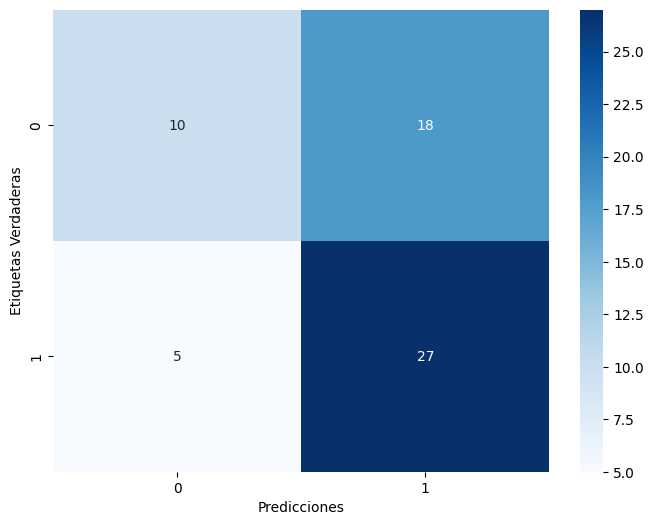

In [ ]:
# Importa las bibliotecas necesarias
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
#from tensorflow.keras.models import load_model

# Realiza predicciones con el modelo
y_pred = modelo_previo.predict(videos_test)
#y_pred = model.predict(videos_test2)

# Convierte las predicciones en clases (por ejemplo, de probabilidades a clases 0 o 1)
y_pred_classes = np.argmax(y_pred, axis=1)

# Evaluación del modelo
print("Matriz de Confusión:")
cm = confusion_matrix(labels_test, y_pred_classes)
print(cm)

print("\nReporte de Clasificación:")
print(classification_report(labels_test, y_pred_classes))

# Visualiza la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicciones')
plt.ylabel('Etiquetas Verdaderas')
plt.show()


2/2 [==============================] - 3s 1s/step - loss: 0.6023 - accuracy: 0.6833


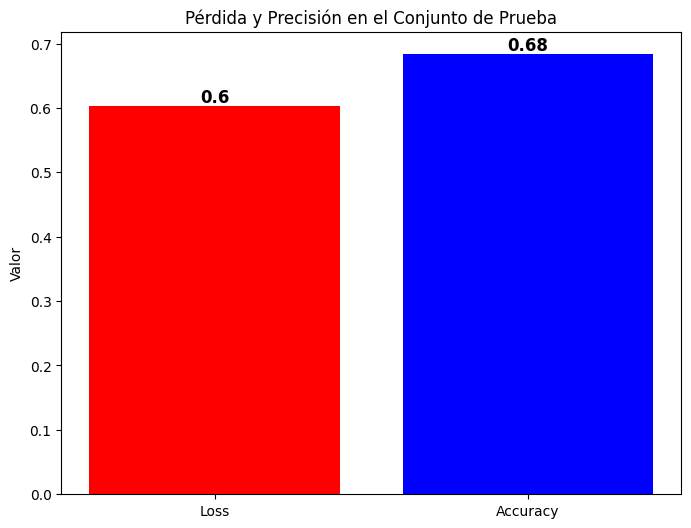

In [ ]:
import matplotlib.pyplot as plt

# Realiza la evaluación en el conjunto de prueba
loss_test, accuracy_test = modelo_previo.evaluate(videos_test, labels_test2)

# Crea una gráfica de barras para mostrar la pérdida y la precisión en el conjunto de prueba
plt.figure(figsize=(8, 6))

# Etiquetas para las barras
labels = ['Loss', 'Accuracy']
values = [loss_test, accuracy_test]

# Colores para las barras
colors = ['red', 'blue']

# Genera las barras
plt.bar(labels, values, color=colors)

# Muestra los valores en las barras
for i, v in enumerate(values):
    plt.text(i, v, str(round(v, 2)), ha='center', va='bottom', fontsize=12, fontweight='bold', color='black')

plt.ylabel('Valor')
plt.title('Pérdida y Precisión en el Conjunto de Prueba')

plt.show()


In [ ]:
# Guardar el modelo nuevamente entrenado
modelo_previo.save('/content/drive/My Drive/Colab Notebooks/VD/modelo_actualizado9.h5')
modelo_previo.save_weights("/content/drive/My Drive/Colab Notebooks/VD/pesos_modelo9.h5")